In [57]:
import bbi
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
import glob
sns.set_style("white")
from numpy import unravel_index
import statistics
import math
import pandas as pd
import os
from tqdm import tqdm

from dotenv import load_dotenv
assert os.environ['CONDA_DEFAULT_ENV'] == "cultures_hic"
load_dotenv()

True

In [58]:
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Helvetica'
mpl.rc('lines', linewidth=0.4)
mpl.rc('font', family='Helvetica', size=8)
mpl.rc('axes', labelsize=8, titlesize=8, linewidth=0.4)
mpl.rc('legend', fontsize=8)
mpl.rc('xtick', labelsize=6)
mpl.rc('xtick.major', width=0.4, size=2)
mpl.rc('xtick.minor', width=0.4, size=1)
mpl.rc('ytick', labelsize=6)
mpl.rc('ytick.major', width=0.4, size=2)
mpl.rc('ytick.minor', width=0.4, size=1)

In [14]:
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [66]:
path_to_mapping = os.getenv('PATH_TO_MAIN_MAPS_MAPPING')

# 1. Prepare bigwig files

In [55]:
files_directory = './tad_borders_files/'
save_directory = "./tad_borders_bigwigs/"
files = os.listdir(files_directory)
files = [i for i in files if "full_insulation_score_" in i]

In [59]:
for file_name in tqdm(files):
    file = pd.read_csv(files_directory+file_name)
    file = file[['chrom', 'start', 'end','log2_insulation_score_150000']]
    file.dropna(inplace=True)
    save_name = file_name.split('.csv')[0]+".bed"
    file.to_csv(f'{save_directory}/{save_name}', index=False, sep='\t', header=None)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:26<00:00,  1.15s/it]


In [62]:
#convert bed to bigwis
! ./tad_borders_bigwigs/prepare_bw.sh ./tad_borders_bigwigs

Successfully converted ./tad_borders_bigwigs/full_insulation_score_Ballerino2022_NES_5kb_drop_diag_5kb_15res_150wind.bed to ./tad_borders_bigwigs/full_insulation_score_Ballerino2022_NES_5kb_drop_diag_5kb_15res_150wind.bw
Successfully converted ./tad_borders_bigwigs/full_insulation_score_Ballerino2022_NPC_5kb_drop_diag_5kb_15res_150wind.bed to ./tad_borders_bigwigs/full_insulation_score_Ballerino2022_NPC_5kb_drop_diag_5kb_15res_150wind.bw
Successfully converted ./tad_borders_bigwigs/full_insulation_score_Ballerino2022_iPSC_NeuNplus_sampled_exact_mcool_15res_150wind.bed to ./tad_borders_bigwigs/full_insulation_score_Ballerino2022_iPSC_NeuNplus_sampled_exact_mcool_15res_150wind.bw
Successfully converted ./tad_borders_bigwigs/full_insulation_score_Heffel_2T_3056_cells_5kb_15res_150wind.bed to ./tad_borders_bigwigs/full_insulation_score_Heffel_2T_3056_cells_5kb_15res_150wind.bw
Successfully converted ./tad_borders_bigwigs/full_insulation_score_Heffel_3T_3056_cells_5kb_15res_150wind.bed to .

# 2. Plot insulation profile around TAD borders

In [114]:
def prepare_borders(boundaries_unique):
    boundaries_unique = boundaries_unique.iloc[:, [0,1,2]].copy().drop_duplicates()
    boundaries_unique.columns = ['ch', 'start', 'end']
    boundaries_unique['border_center'] = (boundaries_unique.end + boundaries_unique.start)//2
    boundaries_unique.border_center = [int(i) for i in boundaries_unique.border_center]
    boundaries_unique = boundaries_unique[boundaries_unique.ch.isin([ 'chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21',
       'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9'])]    
    return boundaries_unique
    
def make_df(path, boundaries_file, window, prepared=True):
    if not prepared:
        boundaries_file = prepare_borders(boundaries_file)
    nbins = round(window * 2 / 10000)    
    s = bbi.stackup(path, boundaries_file.ch, boundaries_file.border_center - window, boundaries_file.border_center + window, bins=nbins) 
    
    df = pd.DataFrame(s)
    df = df.T
    df["bin"] = [i for i in range(df.shape[0])]
    df = pd.melt(df, id_vars='bin').rename(columns = {"variable":"sample"})
    return s, df
    
def create_profiles(tads, shortname2group, bw_files2name, window=100000):
    """
    Creates profiles from the given TADs data, shortname to group mapping, and bigwig file names.
    
    Parameters:
    - tads: DataFrame containing the TADs data.
    - shortname2group: Dictionary mapping short names to their respective groups.
    - bw_files2name: Dictionary mapping sample names to bigwig file names.
    - window: Integer specifying the window size for analysis (default is 100000).
    
    Returns:
    - profiles_dfs: Dictionary of DataFrames containing profiles for each group.
    """
    try:
        tads_layouts = {
            "iPSC-derived neurons": tads[tads.Group == "iPSC-derived neurons"].iloc[:, :3].drop_duplicates(),
            "Post-mortem neurons": tads[tads.Group != "iPSC-derived neurons"].iloc[:, :3].drop_duplicates()
        }

        nbins = round(window * 2 / 10000)
        profiles = {group: {} for group in tads.Group.unique()}
        profiles_all = {group: {} for group in tads.Group.unique()}

        for group in tads.Group.unique():
            print(f"Processing group: {group}")
            samples_selected = [sample for sample, grp in shortname2group.items() if grp == group]
            
            for sample in samples_selected:
                if sample not in bw_files2name:
                    print(f"Warning: No bigwig file found for sample {sample}. Skipping.")
                    continue
                
                bw_selected = bw_files2name[sample]
                tads_selected = tads_layouts[group]
                s, res = make_df(bw_selected, tads_selected, window, prepared=False)
                
                print(f"Sample {sample} shape: {s.shape}")
                profiles[group][sample] = res
                profiles_all[group][sample] = s

        profiles_dfs = {}
        for group in tads.Group.unique():
            print(f"Compiling profiles for group: {group}")
            samples_selected = [sample for sample, grp in shortname2group.items() if grp == group]
            dfs = pd.DataFrame()
            
            for sample in samples_selected:
                if sample not in profiles[group]:
                    continue
                
                df = profiles[group][sample]
                df = df.set_index(['bin', 'sample'])
                df.rename(columns={"value": sample}, inplace=True)
                dfs = pd.concat([dfs, df], axis=1)
            
            profiles_dfs[group] = dfs

        return profiles_dfs

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [138]:
def extract_name(file_name):
    patterns = [
        '_5kb_drop_diag_5kb_15res_150wind',
        '_sampled_exact',
        '_drop_diag',
        '_CRISPRi',
        '_3056_cells',
        '_EN_IN'
    ]
    file_name = file_name.split('full_insulation_score_')[1]
    for pattern in patterns:        
        file_name = file_name.split(pattern)[0]
    return file_name

def create_bw_files2name(files, save_directory, shortname2group):
    """
    Creates a mapping from reduced file names to full file paths and validates against a given group.

    Parameters:
    files (list): List of file names to process.
    save_directory (str): Directory prefix for the file paths.
    shortname2group (dict): Dictionary mapping short names to groups for validation.

    Returns:
    dict: A dictionary mapping reduced names to full file paths.
    """
    file_names = []
    bw_files2name = {}

    for file_name in files:
        name_reduced = extract_name(file_name)
        file_names.append(name_reduced)
        full_path = save_directory + file_name
        bw_files2name[full_path] = name_reduced

    missing_names = shortname2group.keys() - set(file_names)
    if missing_names:
        raise ValueError(f"Missing names in file names: {missing_names}")

    inverted_bw_files2name = {v: k for k, v in bw_files2name.items()}

    return inverted_bw_files2name

def make_xlabels(window, sizes = [6, 4.7]): 
    nbins = round(window * 2 / 10000)      
    fig, ax = plt.subplots(figsize=sizes)
    x_labels = []
    for i in np.arange(-window / 1000, 1 + window / 1000, window / 1000).astype(int):
        x_labels.append(f'{i} kb')
    ax.set_xticklabels(x_labels, rotation=0)
    ax.set_xticks(np.array([0., nbins//2-1, nbins-1]))
    return ax, nbins

def plot_profile(profiles_dfs, save_name="insulation_profile", window =100000, errorbar='ci', method='mean', output_dir="./tads_visualizations/"):
    """
    Plots the profile of given DataFrame groups with specified error bars and method.

    Parameters:
    - profiles_dfs (dict): A dictionary where keys are group names and values are DataFrames.
    - save_name (str): The name for the saved plot file.
    - errorbar (str): The type of error bar to display, e.g., 'ci' for confidence interval.
    - method (str): The statistical method to use, e.g., 'mean'.
    - output_dir (str): Directory where the plot will be saved.

    Returns:
    - None
    """
    try:
        ax, nbins = make_xlabels(window, [3, 3])
    except NameError as e:
        raise NameError("The function 'make_xlabels' or variable 'window' is not defined.") from e

    palette = {
        'iPSC-derived neurons': '#469433',
        'Stem-like cells': 'dimgrey',
        'Post-mortem neurons': '#034e91'
    }

    for group, df in profiles_dfs.items():
        if not isinstance(df, pd.DataFrame):
            raise ValueError(f"The value for '{group}' is not a pandas DataFrame.")

        try:
            df_mean = df.mean(axis=1).to_frame(name='value').reset_index()
            df_mean.columns = ['bin','sample', 'value']
            sns.lineplot(data=df_mean, x='bin', y='value',
                         color=palette.get(group, 'black'),  # Default to 'black' if group not in palette
                         errorbar=errorbar, estimator=method,
                         label=group, ax=ax)
        except Exception as e:
            raise RuntimeError(f"Error processing group '{group}': {e}")

    plt.tight_layout()
    plt.ylim(-0.55, 0.23)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    os.makedirs(output_dir, exist_ok=True)
    save_path = os.path.join(output_dir, f"{save_name}.pdf")

    try:
        plt.savefig(save_path, bbox_inches='tight', format="pdf")
    except Exception as e:
        raise IOError(f"Failed to save plot to {save_path}: {e}")

    plt.show()

In [123]:
save_directory = "./tad_borders_bigwigs/"
files = os.listdir(save_directory)
files = [i for i in files if ".bw" in i]
mapping = pd.read_feather(f'{path_to_mapping}/main_files_mapping.feather')
shortname2group  = dict(mapping[['sample_init', 'Group']].values)
shortname2group = {
    ('Rajarajan_NPC' if key == 'Rajarajan_NPC_5kb' else
     'Zaghi2023_NPC' if key == 'Zaghi2023_NPC_5kb' else key): value
    for key, value in shortname2group.items()
}
bw_files2name = create_bw_files2name(files, save_directory, shortname2group)

In [ ]:
path_to_tads_borders_properties_dataframe = os.getenv('PATH_TO_TADS_BORDERS_PROPERTIES_DATAFRAME')
tads_borders = pd.read_pickle(path_to_tads_borders_properties_dataframe)
tads_borders.status_combined.unique()

In [19]:
tads_borders_neuronal = tads_borders[tads_borders.status_by_mu == 'up_in_post_mortem']
tads_borders_cultural = tads_borders[tads_borders.status_by_mu == 'down_in_post_mortem']
tads_borders_all = tads_borders[~tads_borders.status_by_mu.isin(['up_in_post_mortem', 'down_in_post_mortem'])]

/tmp/ipykernel_2369584/1631460611.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=0)


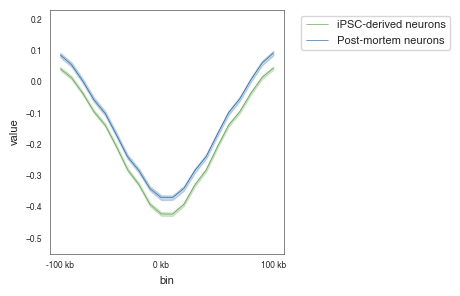

In [139]:
profiles_dfs = create_profiles(tads_borders_all, shortname2group, bw_files2name)
plot_profile(profiles_dfs, save_name= "insulation_profile_not_differential")

Processing group: iPSC-derived neurons
Sample Ballerino2022_iPSC_NeuNplus shape: (596, 20)
Sample Our_data_iPSC_NeuNplus shape: (596, 20)
Sample Li2022_iPSC_NeuNplus shape: (596, 20)
Sample Rajarajan_iPSC_NeuNplus shape: (596, 20)
Sample Rahman2023_iPSC_NeuNplus shape: (596, 20)
Sample Wu2021_iPSC_NeuNplus shape: (596, 20)
Sample Zaghi2023_iPSC_NeuNplus shape: (596, 20)
Processing group: Post-mortem neurons
Sample Heffel_adult shape: (732, 20)
Sample Hu2021_NeuNplus shape: (732, 20)
Sample Pletenev2024_NeuNplus shape: (732, 20)
Sample Rahman2023_NeuNplus shape: (732, 20)
Sample Tian2023_NeuNplus shape: (732, 20)
Compiling profiles for group: iPSC-derived neurons
Compiling profiles for group: Post-mortem neurons


/tmp/ipykernel_2369584/1631460611.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=0)


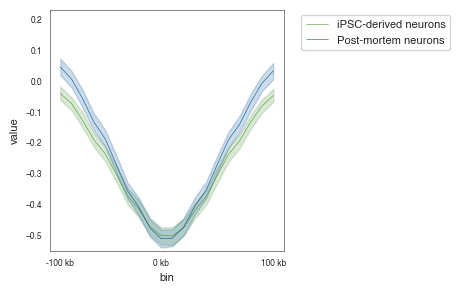

In [141]:
profiles_dfs = create_profiles(tads_borders_neuronal, shortname2group, bw_files2name)
plot_profile(profiles_dfs, save_name= "insulation_profile_up_in_post_mortem")

Processing group: iPSC-derived neurons
Sample Ballerino2022_iPSC_NeuNplus shape: (920, 20)
Sample Our_data_iPSC_NeuNplus shape: (920, 20)
Sample Li2022_iPSC_NeuNplus shape: (920, 20)
Sample Rajarajan_iPSC_NeuNplus shape: (920, 20)
Sample Rahman2023_iPSC_NeuNplus shape: (920, 20)
Sample Wu2021_iPSC_NeuNplus shape: (920, 20)
Sample Zaghi2023_iPSC_NeuNplus shape: (920, 20)
Processing group: Post-mortem neurons
Sample Heffel_adult shape: (619, 20)
Sample Hu2021_NeuNplus shape: (619, 20)
Sample Pletenev2024_NeuNplus shape: (619, 20)
Sample Rahman2023_NeuNplus shape: (619, 20)
Sample Tian2023_NeuNplus shape: (619, 20)
Compiling profiles for group: iPSC-derived neurons
Compiling profiles for group: Post-mortem neurons


/tmp/ipykernel_2369584/1631460611.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=0)


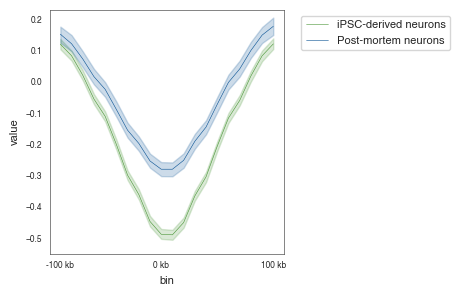

In [142]:
profiles_dfs = create_profiles(tads_borders_cultural, shortname2group, bw_files2name)
plot_profile(profiles_dfs, save_name= "insulation_profile_down_in_pm")